In [ ]:
# Google Drive'ı bağlama
from google.colab import drive
drive.mount('/content/drive')

# Gerekli kütüphaneleri yükleme
!pip install wordcloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# NLTK verilerini indirme
nltk.download('stopwords')

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Zip dosyasını yükleme
from google.colab import files
uploaded = files.upload()

# Yüklenen zip dosyasının adını bulma
zip_filename = list(uploaded.keys())[0]
print(f"Yüklenen dosya: {zip_filename}")

# Zip dosyasını çıkarma
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall("twitter_data")
    print("Zip dosyası başarıyla çıkarıldı.")

# Çıkarılan dosyaları listeleme
print("\nÇıkarılan dosyalar:")
!ls twitter_data

Saving archive.zip to archive.zip
Yüklenen dosya: archive.zip
Zip dosyası başarıyla çıkarıldı.

Çıkarılan dosyalar:
training.1600000.processed.noemoticon.csv


In [ ]:
# Çıkarılan dosyalardan veri setini bulma
extracted_files = os.listdir("twitter_data")
csv_files = [f for f in extracted_files if f.endswith('.csv')]

if not csv_files:
    raise FileNotFoundError("CSV dosyası bulunamadı")

csv_path = f"twitter_data/{csv_files[0]}"
print(f"\nVeri seti bulundu: {csv_path}")

# Farklı kodlamalarla veriyi yükleme
encodings = ['utf-8', 'latin-1', 'ISO-8859-1', 'cp1252']

for encoding in encodings:
    try:
        df = pd.read_csv(csv_path, encoding=encoding)
        print(f"✅ Başarılı: {encoding} kodlaması ile yüklendi")
        break
    except UnicodeDecodeError:
        print(f"❌ Hata: {encoding} kodlaması çalışmadı")
    except Exception as e:
        print(f"⚠️ Diğer Hata ({encoding}): {str(e)}")

# Veriyi kontrol etme
if 'df' in locals():
    print("\nVeri seti başarıyla yüklendi!")
    print("Veri boyutu:", df.shape)
    print("\nİlk 5 kayıt:")
    print(df.head())
    print("\nSütunlar:", df.columns.tolist())
else:
    print("\nVeri yüklenemedi. Lütfen dosya formatını kontrol edin.")


Veri seti bulundu: twitter_data/training.1600000.processed.noemoticon.csv
❌ Hata: utf-8 kodlaması çalışmadı
✅ Başarılı: latin-1 kodlaması ile yüklendi

Veri seti başarıyla yüklendi!
Veri boyutu: (1599999, 6)

İlk 5 kayıt:
   0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY _TheSpecialOne_  \
0  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   scotthamilton   
1  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY        mattycus   
2  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY         ElleCTF   
3  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          Karoli   
4  0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY        joy_wolf   

  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  
0  is upset that he can't update his Facebook by ...                                                                   
1  @Kenichan I dived many times for the ball. Man...                            

In [ ]:
# Veri setini yeniden yükleme ve sütun isimlerini ayarlama
df = pd.read_csv(csv_path, encoding=encoding, header=None, names=['target', 'ids', 'date', 'flag', 'user', 'text'])  # Sütun isimlerini belirtiyoruz
df = df[['text', 'target']]  # Sadece 'text' ve 'target' sütunlarını seçiyoruz
df.columns = ['text', 'label']  # Sütun isimlerini 'text' ve 'label' olarak değiştiriyoruz

# Veriyi kontrol etme
print("\nGüncellenmiş veri seti:")
print(df.head())


Güncellenmiş veri seti:
                                                text  label
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...      0
1  is upset that he can't update his Facebook by ...      0
2  @Kenichan I dived many times for the ball. Man...      0
3    my whole body feels itchy and like its on fire       0
4  @nationwideclass no, it's not behaving at all....      0


In [ ]:
# Metin temizleme fonksiyonlarını uygulama (artık 'text' sütunu var)
df['cleaned_text'] = df['text'].apply(clean_text)
df['cleaned_text'] = df['cleaned_text'].apply(remove_stopwords)
df['cleaned_text'] = df['cleaned_text'].apply(apply_stemming)

# Kontrol
print("\nTemizlenmiş metin örnekleri:")
print(df[['text', 'cleaned_text']].head())


Temizlenmiş metin örnekleri:
                                                text  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1  is upset that he can't update his Facebook by ...   
2  @Kenichan I dived many times for the ball. Man...   
3    my whole body feels itchy and like its on fire    
4  @nationwideclass no, it's not behaving at all....   

                                        cleaned_text  
0       that bummer shoulda got david carr third day  
1  upset cant updat facebook text might cri resul...  
2       dive mani time ball manag save rest go bound  
3                    whole bodi feel itchi like fire  
4                              behav im mad cant see  


In [ ]:
# Özellik çıkarımı
from sklearn.feature_extraction.text import CountVectorizer # Import CountVectorizer

vectorizer = CountVectorizer() # Initialize CountVectorizer
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['label']  # Label sütununu kullanıyoruz

# Veriyi bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model eğitimi
model = MultinomialNB()
model.fit(X_train, y_train)

# Tahminler
y_pred = model.predict(X_test)

In [ ]:
# Model nesnesinin özelliklerini kontrol etme
print("Model parametreleri:", model.get_params())

# Modelin eğitilip eğitilmediğini kontrol etme
if hasattr(model, 'classes_'):
    print("\n✅ Model başarıyla eğitildi!")
    print("Sınıflar:", model.classes_)
    print("Özellik sayısı:", model.n_features_in_)
else:
    print("\n❌ Model eğitilmemiş!")

Model parametreleri: {'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': True}

✅ Model başarıyla eğitildi!
Sınıflar: [0 4]
Özellik sayısı: 370371


In [ ]:
# Eğitim seti üzerinde doğruluk kontrolü
train_score = model.score(X_train, y_train)
print(f"\nEğitim seti doğruluk oranı: {train_score:.2%}")

# Test seti üzerinde doğruluk kontrolü
test_score = model.score(X_test, y_test)
print(f"Test seti doğruluk oranı: {test_score:.2%}")

# Sınıflandırma raporu
print("\nDetaylı sınıflandırma raporu:")
print(classification_report(y_test, y_pred))


Eğitim seti doğruluk oranı: 80.05%
Test seti doğruluk oranı: 76.64%

Detaylı sınıflandırma raporu:
              precision    recall  f1-score   support

           0       0.76      0.78      0.77    159494
           4       0.78      0.75      0.76    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



In [ ]:
# Örnek bir tahmin yapma
sample_text = "I really love this product, it's amazing!"
prediction = model.predict(vectorizer.transform([sample_text]))
print(f"\nÖrnek tahmin ('{sample_text}'): {prediction[0]}")

# Tahmin olasılıklarını görme
probabilities = model.predict_proba(vectorizer.transform([sample_text]))
print(f"Tahmin olasılıkları: {probabilities}")


Örnek tahmin ('I really love this product, it's amazing!'): 4
Tahmin olasılıkları: [[0.10727334 0.89272666]]


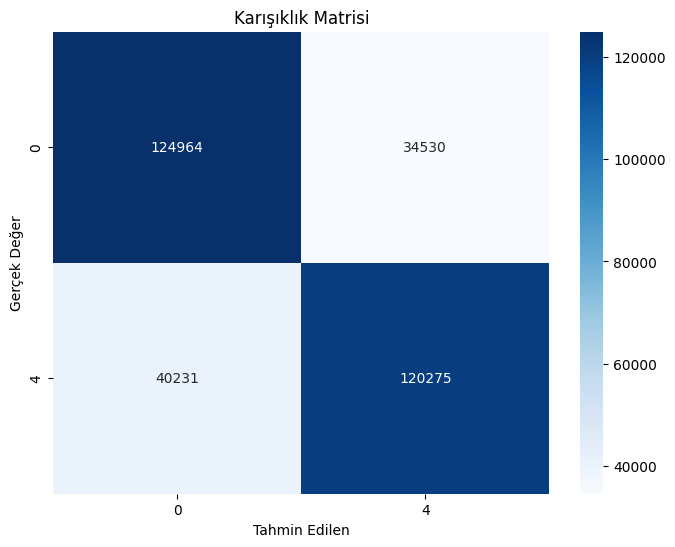

In [ ]:
# Karışıklık matrisi görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.title('Karışıklık Matrisi')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek Değer')
plt.show()

In [ ]:
# En önemli kelimeleri görüntüleme
def show_top_features(vectorizer, model, n=20):
    feature_names = vectorizer.get_feature_names_out()
    coefs = model.feature_log_prob_

    print("En önemli pozitif kelimeler:")
    print([feature_names[i] for i in coefs[1].argsort()[-n:][::-1]])

    print("\nEn önemli negatif kelimeler:")
    print([feature_names[i] for i in coefs[0].argsort()[-n:][::-1]])

show_top_features(vectorizer, model)

En önemli pozitif kelimeler:
['im', 'good', 'love', 'go', 'day', 'thank', 'get', 'like', 'lol', 'time', 'today', 'see', 'got', 'work', 'one', 'know', 'new', 'watch', 'great', 'well']

En önemli negatif kelimeler:
['im', 'go', 'get', 'work', 'day', 'miss', 'dont', 'cant', 'like', 'want', 'today', 'feel', 'got', 'back', 'realli', 'time', 'good', 'still', 'one', 'sad']


In [ ]:
from sklearn.model_selection import cross_val_score

# 5 katlı çapraz doğrulama
cv_scores = cross_val_score(model, X, y, cv=5)
print(f"\nÇapraz doğrulama sonuçları: {cv_scores}")
print(f"Ortalama doğruluk: {cv_scores.mean():.2%} (±{cv_scores.std():.2%})")


Çapraz doğrulama sonuçları: [0.76088437 0.75628125 0.75701875 0.76584375 0.7594875 ]
Ortalama doğruluk: 75.99% (±0.34%)
